## INFO7390 Assignment - 1

Submission notebook: <b>Vraj Mashruwala</b>

## Assignment objective: 
Implement a basic k means clustering algorithm, ideally as a set of functions*. Run it on any dataset of your choice or on the attached online retail dataset. Provide a simple visualization of its results.

#### Dataset: 
I am using a loan applicants dataset found online. In order to avoid complexities, I consider 2 features for this k-means implementation: applicant income and loan amount. This would help clustering customers in terms of income and loan amounts.

The flow of this notebook follows defining functions for each step and then calling all the necessary functions later on to perform the related tasks!

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Read and pre-process the data

In [2]:
df = pd.read_csv('loan_dataset.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [4]:
data = df[['ApplicantIncome', 'LoanAmount']] #filter out the data we need
data.head(10)

,ApplicantIncome,LoanAmount
0,4583,128.0
1,3000,66.0
2,2583,120.0
3,6000,141.0
4,2333,95.0
5,3200,70.0
6,2500,109.0
7,1853,114.0
8,1299,17.0
9,4950,125.0


Have a look at the data distribution in order to check for any skewness

/Users/vraj/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'DISTPLOT FOR APPLICANT INCOME')

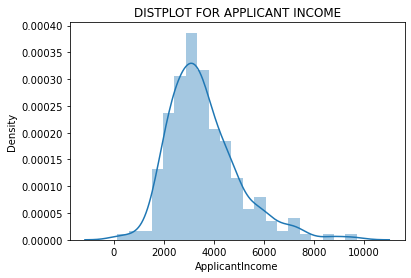

In [5]:
plt.figure(figsize=(6, 4))
sns.distplot(data['ApplicantIncome'])

plt.title('DISTPLOT FOR APPLICANT INCOME') 

/Users/vraj/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'DISTPLOT FOR LOAN AMOUNT')

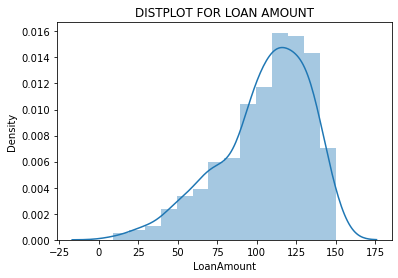

In [6]:
plt.figure(figsize=(6, 4))
sns.distplot(data['LoanAmount'])

plt.title('DISTPLOT FOR LOAN AMOUNT') 

The data does not seem skewed. Let's move onto normalizing the data

In [7]:
#normalizing the data to be between 0 and 1
data_normalized = data.copy()
for col in data:
    data_normalized[col] = (data_normalized[col] - np.min(data_normalized[col])) / (np.max(data_normalized[col]) - np.min(data_normalized[col]))

In [8]:
data_normalized.describe()

,ApplicantIncome,LoanAmount
count,381.000000,381.000000
mean,0.359033,0.680758
std,0.148625,0.201124
min,0.000000,0.000000
25%,0.256464,0.574468
50%,0.333194,0.716312
75%,0.433162,0.836879
max,1.000000,1.000000


In [9]:
#all the data points
datapoints = data_normalized.values

## Defining the functions to carry out K-Means Clustering one after the other
The working of each function is given as description

In [10]:
def initialize_centroids(datapoints, K):
    ''' This function randomly initializes the centroid datapoints for each of the K clusters'''
    
    size = datapoints.shape[1]
    centroids = [] #to store all centroid points
    
    for cluster in range(K):
        point = np.random.uniform(datapoints.min(), datapoints.max(), size)
        centroids.append(point)
    
    return centroids

In [11]:
def cluster_allocation(datapoints, centroids):
    ''' This function performs the cluster assignment for all datapoints by finding the nearest centroid point. 
    It calculates the Euclidean distance between each datapoint and each centroid point to find nearest centroid.
    This function returns a list of allocations of the length equal to number of data points'''
    
    allocations = [] #to store cluster label allocations for each data point

    for datapoint in datapoints:
        distances = [] 
        
        for centroid in centroids:
            euc_distance = np.linalg.norm(datapoint - centroid) #euclid distance between datapoint and all centroids
            distances.append(euc_distance)
        
        allocation = np.argmin(distances) #datapoint is allocated to the nearest centroid
        allocations.append(allocation)

    return allocations

In [12]:
def update_centroids(datapoints, centroids, allocations, K):
    '''This function is used to update the centroid points for all clusters to new points. The new centroid 
    is calculated by computing the mean of all datapoints allocated to a cluster. The function retrns the
    updated centroids as a list'''
    
    updated_centroids = [] #to store new centroid points for all clusters
    
    for cluster in range(K):
        points_in_cluster = []
    
        for i in range(len(datapoints)):
            if (allocations[i] == cluster):
                points_in_cluster.append(datapoints[i])
        
        cluster_mean = np.mean(points_in_cluster, axis = 0) #mean of all points in a cluster is the new centroid
        updated_centroids.append(cluster_mean)

    return updated_centroids

In [13]:
def dissimilarity_score_over_all_cluster(datapoints, centroids, allocations):
    '''This function is used to compute the dissimilarity score (C) across all clusters. 
    The euclidean distances between each point and it's centroid is found and squared (this is the error). 
    Then these errors are summed across all datapoints to find the dissimilarity score (C) of that cluster'''
    
    errors = [] #to store distances between each point and the assigned centroid (error)
    
    for i in range(len(datapoints)):
        centroid = centroids[allocations[i]] #find allocated cluster
        euc_distance = np.linalg.norm(np.array(datapoints[i]) - np.array(centroid)) #compute distance 
        errors.append(euc_distance**2) #error (squared distance)
        
    dissimilarity_score = sum(errors) #dissimilarity score over all cluster is the sum of errors
    
    return dissimilarity_score

In [14]:
def kmeans(datapoints, K, iterations = 100):
    '''This function implements the K-means Clustering algorithm. It initializes the centroids, assigns all data 
    points to a centroid (clustering) and updates the centroid based on error/variability. The iterations allow you to
    repeatedly update the centroid allocations and the centroid points while optimizing for C (dissimilarity score).
    This function returns the centroid points, the cluster allocation for each datapoint & the dissimilarity score'''
    
    i = 0
    dissimilarity_scores = []
    allocations = []
    
    centroids = initialize_centroids(datapoints, K) #initializing K centroids

    while (len(dissimilarity_scores) <= 1 or i < iterations):
        
        allocations = cluster_allocation(datapoints, centroids) #allocating datapoints to closest centroid
        centroids = update_centroids(datapoints, centroids, allocations, K) #compute and update centroids
        dissimilarity_score = dissimilarity_score_over_all_cluster(datapoints, centroids, allocations) #calculate C
        dissimilarity_scores.append(dissimilarity_score)
        
        if (i == 0):
            i += 1
            continue
        
        #check for convergence
        else:
            if(np.absolute(dissimilarity_scores[i] - dissimilarity_scores[i-1]) / dissimilarity_scores[i-1] >= 0.01):
                break #stopping criteria
            else: 
                i += 1
        
    return (centroids, allocations, dissimilarity_scores)

In [15]:
def plot_clusters(datapoints, fitted_kmeans):
    '''This function plots the clustered data along with the clusters centroid to show an easy to read plot.
    The function does not return anything, rather just prints out the plot'''
    
    colors = ['green', 'cyan', 'magenta', 'red', 'blue']
    plt.figure(figsize = (8, 6))  
    
    for i in range(len(fitted_kmeans[0])): #number of clusters
        for x in range(len(datapoints)):
            if (fitted_kmeans[1][x] == i): #find all data points of a cluster
                plt.scatter(datapoints[x,0], datapoints[x,1], c = colors[i]) #plot datapoints of a cluster
        plt.scatter(fitted_kmeans[0][i][0], fitted_kmeans[0][i][1], c = 'black', s = 300) #plot centroid of a cluster
    
    plt.title('CLUSTER PLOT')
    plt.xlabel('Applicant Income')
    plt.ylabel('Loan Amount')

### All the functions are now created.
Let me move onto performing k-means clustering on the dataset

## Performing k-means clustering

Running the algorithm for different values of K. Also capturing the error (dissimilarity score or C) for each case in order to find the optimal value of K later.

In [28]:
error_square_summed = {}
fitted_kmeans = {}

for k in range(1, 6):
    fitted_kmeans[k] = kmeans(datapoints, K = k) #fit the kmeans algorithm for each k
    error_square_summed[k] = fitted_kmeans[k][2][-1]

## Elbow method

The elbow plot plots the errors vs diff value of K, this helps you figure out a good value of k by finding the 'elbow point'. In the elbow plot for our case, you can see that k=2 or k=3 would be a good choice. 

Text(0, 0.5, 'Sum of squared error')

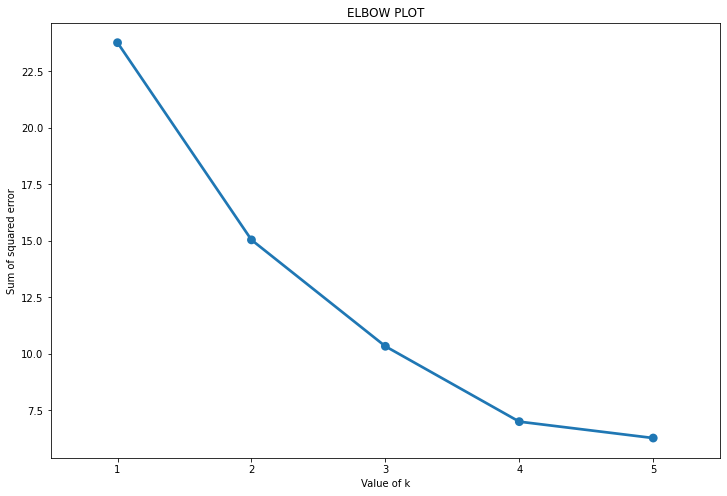

In [29]:
plt.figure(figsize = (12,8))
sns.pointplot(x = list(error_square_summed.keys()), y = list(error_square_summed.values()))

plt.title('ELBOW PLOT')
plt.xlabel('Value of k')
plt.ylabel('Sum of squared error')

## Visualization of Clusters

As seen from the elbow plot above, k=2 or k=3 seems to be a good choice for number of clusters. I will go ahead and visualize the cluster plot for these two values of k

In [30]:
k_2 = fitted_kmeans[2]
k_3 = fitted_kmeans[3]

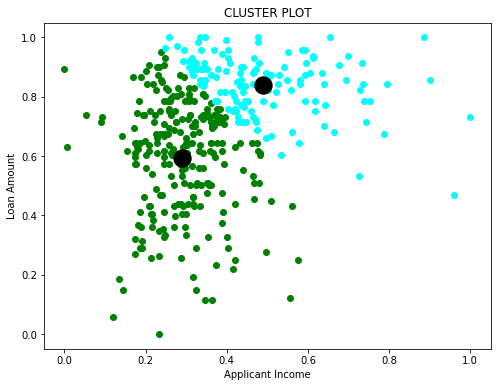

In [31]:
plot_clusters(datapoints, k_2)

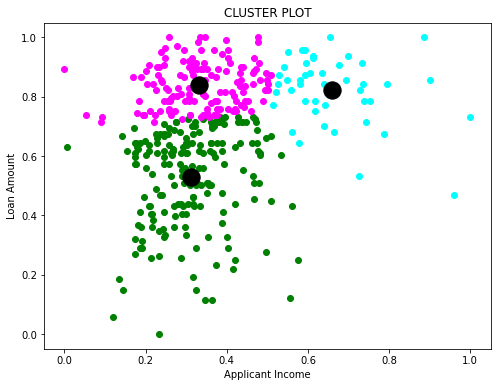

In [32]:
plot_clusters(datapoints,k_3)

## Relative importances & Cluster characteristics

Plotting the relative importances of each attribute with respect to clusters for k = 2

In [33]:
data_cluster = data.copy()
data_cluster['Cluster'] = np.array(k_2[1]) #displaying the original data along with the cluster for each data point

In [34]:
data_cluster

,ApplicantIncome,LoanAmount,Cluster
0,4583,128.0,1
1,3000,66.0,0
2,2583,120.0,0
3,6000,141.0,1
4,2333,95.0,0
...,...,...,...
376,5703,128.0,1
377,3232,108.0,0
378,2900,71.0,0
379,4106,40.0,0


In [35]:
#cluster-wise attribute characteristics
data_cluster.groupby(['Cluster']).agg({ 'ApplicantIncome': 'mean', 'LoanAmount': ['mean', 'count'],}).round(0)

ApplicantIncome LoanAmount      
                   mean       mean count
Cluster                                 
0                2912.0       93.0   248
1                4825.0      128.0   133

In [36]:
cluster_avg = data_cluster.groupby(['Cluster']).mean() #to find relative importance
cluster_avg

,ApplicantIncome,LoanAmount
Cluster,,
0,2911.947581,92.866935
1,4825.248120,127.586466


In [37]:
population_avg = data.mean() #to find relative importance
population_avg

ApplicantIncome    3579.845144
LoanAmount          104.986877
dtype: float64

In [38]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,ApplicantIncome,LoanAmount
Cluster,,
0,-0.19,-0.12
1,0.35,0.22


Text(0.5, 1.0, 'RELATIVE IMPORTANCE OF ATTRIBUTES')

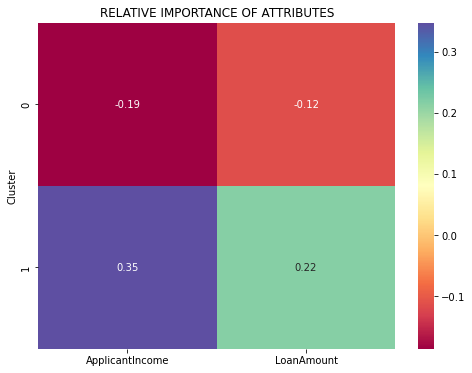

In [39]:
plt.figure(figsize = (8, 6))
sns.heatmap(data = relative_imp, annot = True, fmt = '.2f', cmap = 'Spectral')

plt.title('RELATIVE IMPORTANCE OF ATTRIBUTES') 